In [1]:
import functions as f

import numpy as np
import pandas as pd
from datetime import date
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, LabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score, accuracy_score

## An overview over this business problem

The objective of this exercise is to create a Machine Learning model that allows to predict if a transaction is fraudulent or not by using information about the transaction. From an operational standpoint, this model will label the transaction as fraudulent or not *after* the transaction was done. 

In terms of Machine Learning, this is a *binary classification problem*. This means that the model will use relevant features to predict a *label* (in this case, *is_fraud*) that can have only two possible values (1/*Yes*/fraudulent and 0/*No*/not-fraudulent in this case). As I will explain in the cells below, the *features* used in this case are both *categorical* (i.e.: variables with a given set of values) and *numerical* (i.e.: variables with numerical values). For this case, the algorithm I will use is *gradient boosting*. This algorithm trains an ensemble of many week learners (in this case, decision trees).

The dataset used for this exercise is a synthetic dataset multi-agent virtual world simulation performed by IBM. This dataset contains transactions for 2000 synthetic consumers that have more than 1 card (credit card, debit card, prepaid card, etc.), reside in the USA but also traveled abroad. For more details, the paper can be found [here](https://arxiv.org/abs/1910.03033).

## Development enviorment and deploying tools

In this case, for the sake of simplicity and to avoid issues with the environment variables when another person tries to run this notebook, I will use the *Pandas + Scikit Learn* stack. I will use *Pandas* to load, handle and process the data and *Scikit Learn* to perform the preprocessing operations, train the model and create (and save) a pipeline that contains all these operations. In a productionalization scenario, because of the amount of data, another valid approach to attack this exercise could be to use the *PySpark* stack to take advantage of the parallel computing power.  

To grant the reproducibility of this notebook, the version of the libraries I used to deploy the code are:

1. numpy == 1.21.1
2. pandas == 1.3.1
3. matplotlib == 3.4.2
4. sklearn == 0.24.1

## Loading the data and first exploration

In [2]:
path_to_data = "./data/credit_card_transactions-ibm_v2.csv.zip"
dataset = f.load_data(path_to_data)

print("Number of target users: ", dataset["is_fraud"][dataset.is_fraud == "Yes"].count())
print("Number of no-target users: ", dataset["is_fraud"][dataset.is_fraud == "No"].count())

Number of target users:  29757
Number of no-target users:  24357143


As is explained in the paper, the columns *User* and *Card* are the user number and the number of card associated with a given user, respectively. For example, if user 32 buys something with card number 2, that transaction must have *User* = 32 and *Card* = 2. Therefore, these features have no predictive power and will therefore be removed.

Another relevant issue about this dataset is the imbalance between the *fraudulent* and *non-fraudulent* transactions. This dataset has 29757 *fraudulent* transactions and 24357143 *non-fraudulent* transactions. This means that **only 0.122% of the total transactions are fraudulent**; 1 fraudulent transaction for every 818 non-fraudulent one. This characteristic of the dataset should be taken into account.

Now, I´m going to assess the presence of missing values in the dataset.

In [3]:
f.missing_values_assesment(dataset)

#---------------------------------------#
Nulls values in year: 0
Percentage of missing values in year: 0.0%
#---------------------------------------#
Nulls values in month: 0
Percentage of missing values in month: 0.0%
#---------------------------------------#
Nulls values in day: 0
Percentage of missing values in day: 0.0%
#---------------------------------------#
Nulls values in time: 0
Percentage of missing values in time: 0.0%
#---------------------------------------#
Nulls values in amount: 0
Percentage of missing values in amount: 0.0%
#---------------------------------------#
Nulls values in use_chip: 0
Percentage of missing values in use_chip: 0.0%
#---------------------------------------#
Nulls values in merchant_name: 0
Percentage of missing values in merchant_name: 0.0%
#---------------------------------------#
Nulls values in merchant_city: 0
Percentage of missing values in merchant_city: 0.0%
#---------------------------------------#
Nulls values in merchant_state: 272082

As can be seen in the cell above, the only features with missing values are *zip*, *merchant_state* and *error*. As the missing value in *zip* and *merchant_state* may be associated with the use of a VPN, I will count the number of fraudulent transaction that have missing values in *zip* or *merchant_state*.

In [4]:
#Fraud - zip code nulls
N_zip_fraud = len(dataset[(dataset['is_fraud'] == 'Yes') & \
                          (dataset["zip"].isna())])
N_zip_nan = len(dataset[dataset['zip'].isna()])
perc_zip_fraud = np.round(100*N_zip_fraud/N_zip_nan, 3)

#Fraud - merchant_state nulls
N_mer_fraud = len(dataset[(dataset['is_fraud'] == 'Yes') & \
                          (dataset["merchant_state"].isna())])
N_mer_nan = len(dataset[dataset['merchant_state'].isna()])
perc_mer_fraud = np.round(100*N_mer_fraud/N_mer_nan, 3)

#Fraud - both merchant_sate and zip code nulls
N_both_fraud = len(dataset[(dataset['is_fraud'] == 'Yes') & \
                           (dataset["merchant_state"].isna() & dataset["zip"].isna())])
N_both_nan = len(dataset[(dataset["merchant_state"].isna() & dataset["zip"].isna())])
perc_both_fraud = np.round(100*N_both_fraud/N_both_nan, 3)

print("#NULLS CASES-------------------------------------------------------------------------------------------#")
print(f"The number of fraudulent transaction with missing values in zip are {N_zip_fraud}")
print(f"The number transaction with missing values in zip are {N_zip_nan}")
print(f"Percentage of fraudulent transactions with null zip: {perc_zip_fraud}%")
print("#------------------------------------------------------------------------------------------------------#")
print(f"The number of fraudulent transaction with missing values in merchant_state are {N_mer_fraud}")
print(f"The number transaction with missing values merchant_state are {N_mer_nan}")
print(f"Percentage of fraudulent transactions with null merchant_state: {perc_mer_fraud}%")
print("#------------------------------------------------------------------------------------------------------#")
print(f"The number of fraudulent transaction with missing values in zip and merchant_state are {N_both_fraud}")
print(f"The number transaction with missing values in zip and merchant_state are {N_both_nan}")
print(f"Percentage of fraudulent transactions with null zip and merchant_state: {perc_both_fraud}%")

#NULLS CASES-------------------------------------------------------------------------------------------#
The number of fraudulent transaction with missing values in zip are 24852
The number transaction with missing values in zip are 2878135
Percentage of fraudulent transactions with null zip: 0.863%
#------------------------------------------------------------------------------------------------------#
The number of fraudulent transaction with missing values in merchant_state are 18349
The number transaction with missing values merchant_state are 2720821
Percentage of fraudulent transactions with null merchant_state: 0.674%
#------------------------------------------------------------------------------------------------------#
The number of fraudulent transaction with missing values in zip and merchant_state are 18349
The number transaction with missing values in zip and merchant_state are 2720821
Percentage of fraudulent transactions with null zip and merchant_state: 0.674%


The result in the cell above is very relevant because:
1. for nulls in *zip*, the percentage of fraudulent operations is almost 7 times the ratio for the overall population (0.122% vs 0.863%).
2. for nulls in merchant_state, the percentage of fraudulent operations is almost 5 times that ratio the ratio for the overall population (0.122% vs 0.674%). 
3. From the 29757 total fraudulent transaction, 24852 (83.4%) have *null* values for zip code and *18349* (61.6%) have *null* values for both zip and merchant_state.

These results tell that, when a transaction has an unknown zip or merchant_state, then is much more probable that the transaction is a fraudulent transaction with respect to the population overall value (5 to 7 times, depending on which one of the features looks at). Also, 83.4% of the fraudulent transactions have at least one of these two fields with missing values. So, the transactions with unknown zip and/or merchant_state should be carefully tracked.

## EDA

### First preprocessing: cast the variables to the correct type and parse the amount of the transactions

Before proceeding to the EDA, is necessary to perform some transformations over the data. These transformations are:

1. All the features in this dataset are string by default. Because of that, is necessary to cast them to the correct data type. To automate this process, I created a *data_types.json* dictionary. This dictionary contains all the dataset features and their corresponding types (int, float, or string) to cast them.
2. The *amount* feature is formatted as ${*trasaction_amount*},  and this *transaction_amount* must be parsed and casted as a float. To perform these two tasks, the *data_adequation()* function was deployed. 
3. The feature *time* (transaction time) has minute resolution, and this is an unnecessary high granularity in the data. Because of that,  I parsed the time column to an *hour* column.
4. Almost 98.4% of the values in *errors* are missing values. This can be interpreted as "correct transactions". Because of that, these missing values will be filled with *unknown*.

All these transformations are performed by *data_adequation()* function.

In [5]:
df_prepro = f.data_adequation(df=dataset, data_types_dict="./data_types.json")

### Marginal distribution plots: creation & analysis

After performing all these transformations over the original dataset, the next step is to plot the marginal distributions for each feature to find relevant differences in how each feature is distributed for the different values of the *is_fraud* feature. Because of the high granularity in the *time* feature, I dropped it and, instead, I used the *hour* feature to characterize the time of the transaction. I also dropped the *year* (year of the transaction) feature because the information of in which year (in the past) a transaction was made isn´t relevant for the model. For the *amount* feature, I removed the right tail of the distributions to highlight the differences between both distributions. Because of the high cardinality of the *merchant_name*, *merchant_state*, *merchant_city*, *MCC* and *zip*, I decided to don´t plot them.

To generate all these plots, I deployed a function that calculates the normalized distributions for each feature for each value of the label (*is_fraud* feature).

Yes
29757
No
24357143
dict_keys(['Yes', 'No'])


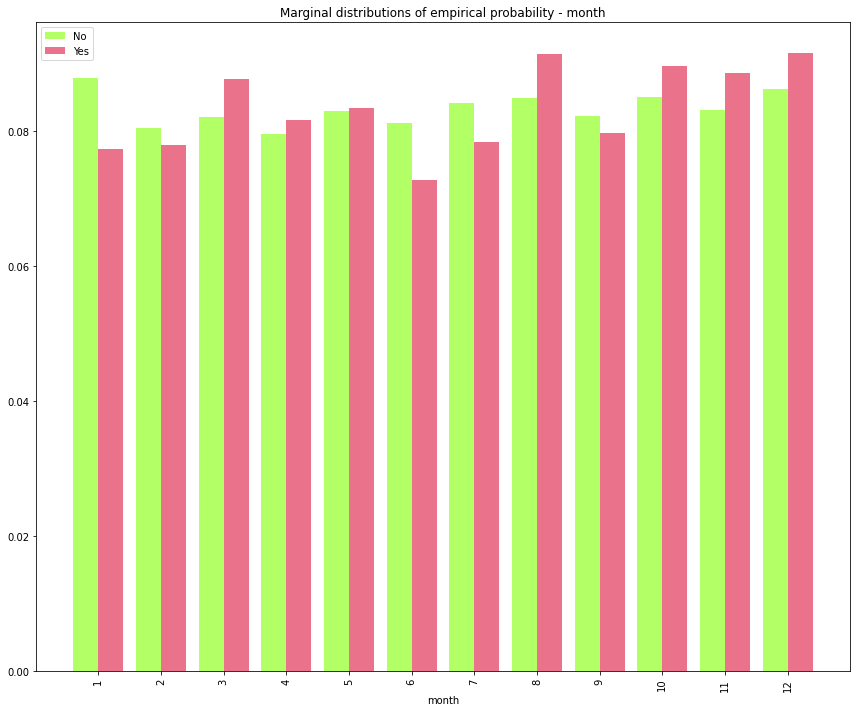

Yes
29757
No
24357143
dict_keys(['Yes', 'No'])


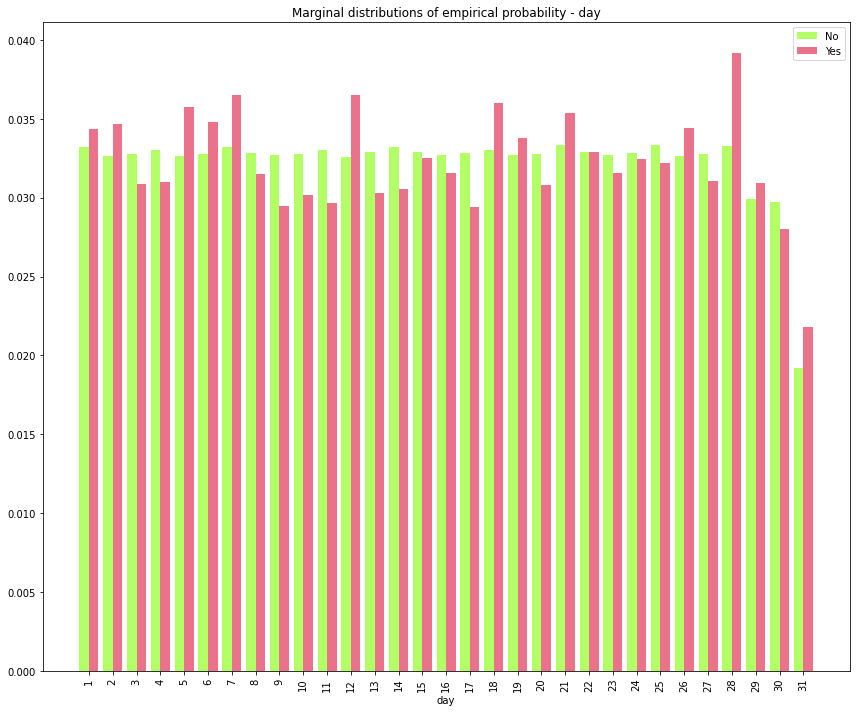

29757
24357143
float64


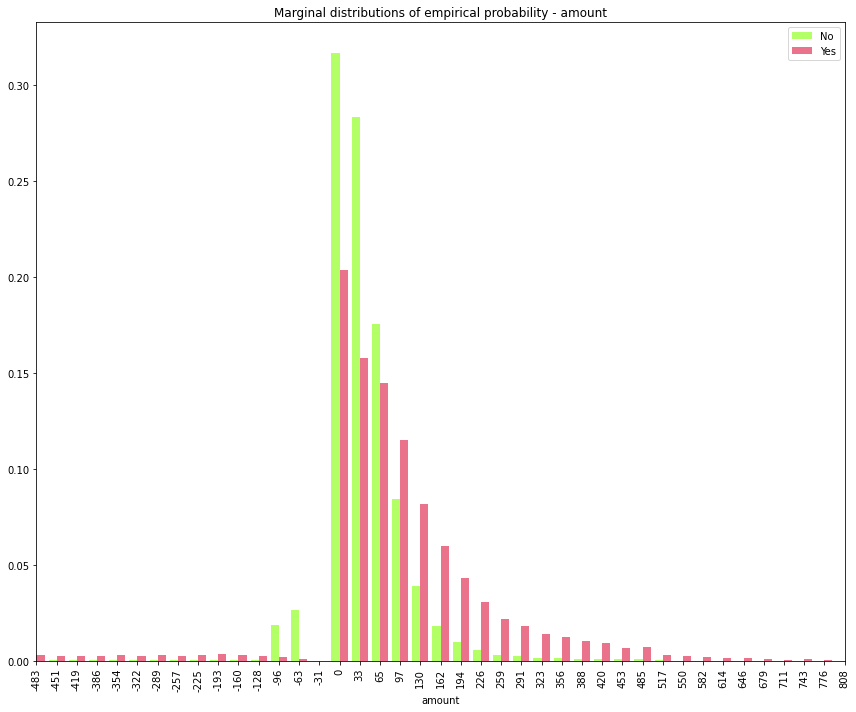

Yes
29757
No
24357143
dict_keys(['Yes', 'No'])


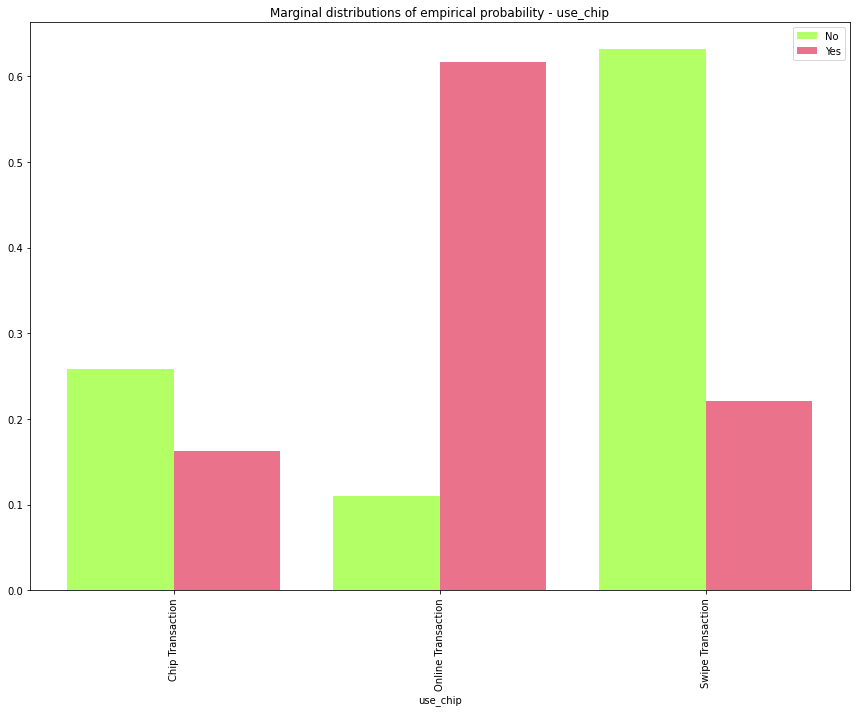

Yes
29757
No
24357143
dict_keys(['Yes', 'No'])


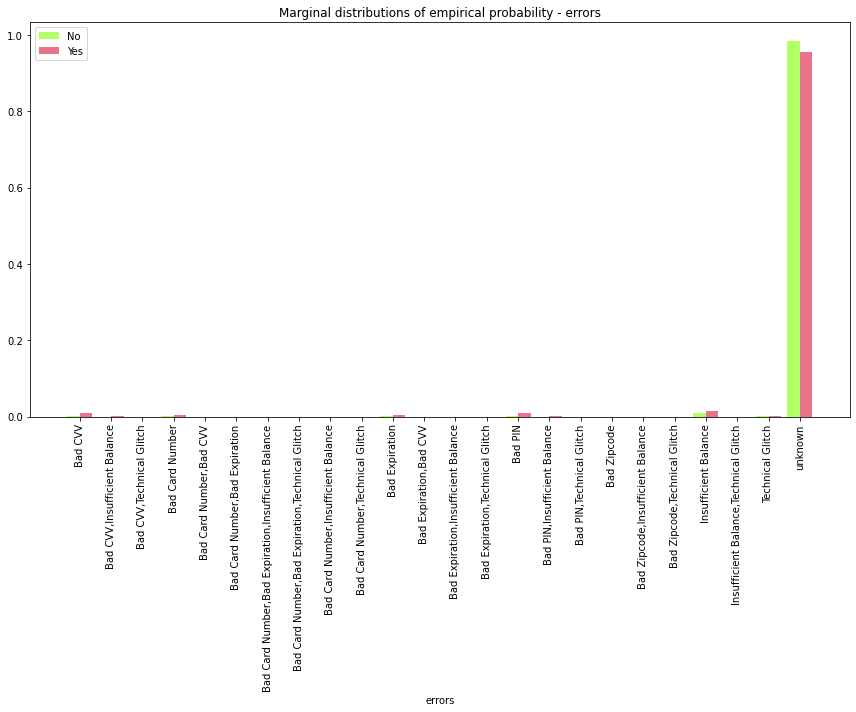

Yes
1286
No
387145
dict_keys(['Yes', 'No'])


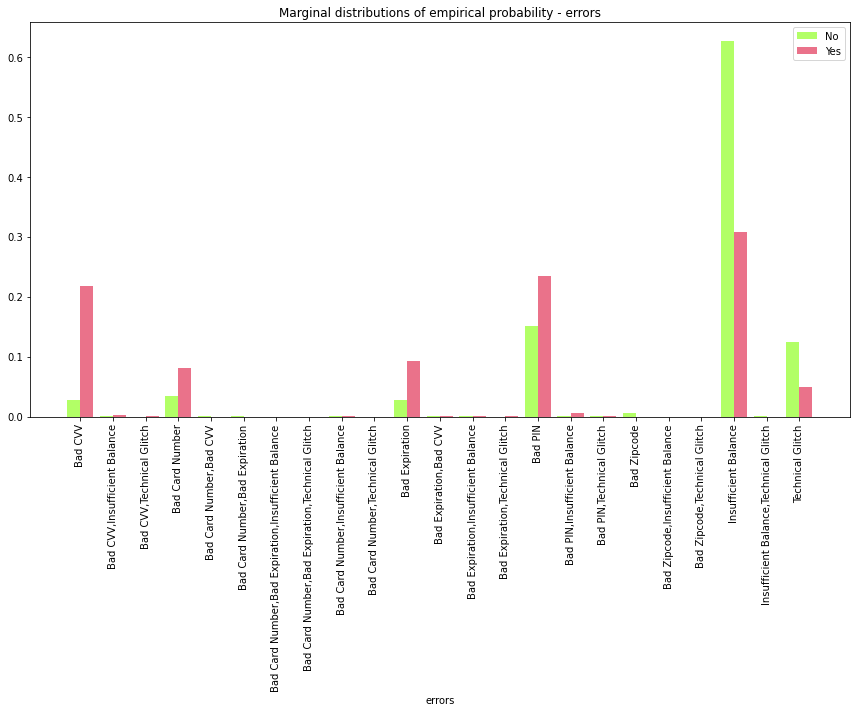

Yes
29757
No
24357143
dict_keys(['Yes', 'No'])


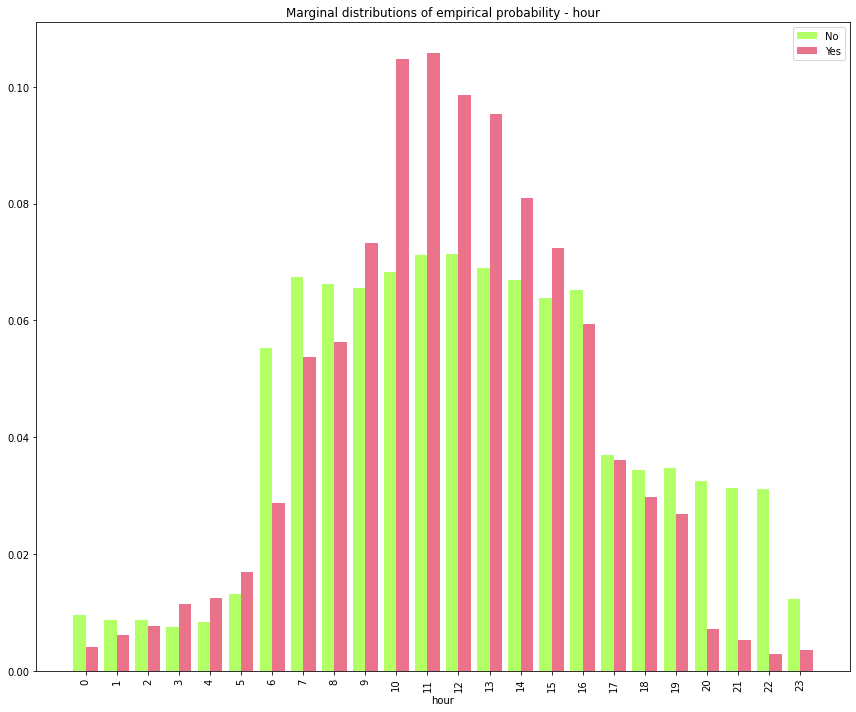

In [6]:
f.features_plotter(df_prepro, cols_to_ignore=["year", "time", "merchant_name", "merchant_city", "merchant_state", "merchant_name", "zip", "MCC"])

Looking at the marginal distributions of the different features, we can find some relevant insights about the fraudulent events:

1. Looking at the *amount* marginal distributions, the fraudulent transactions tend to have higher positive values than the non-fraudulent transactions. Also, in the case of negative values (refunds), the fraudulent transactions tend to have more negative values (bigger refounds) than the non-fraudulent ones.
2. Looking at the *use_chip* marginal distributions, by far the most frequent value for the fraudulent transactions is *online transaction*.
3. Looking at the *hour* marginal distributions, the distribution of the fraudulent transaction has lower variance with respect to the mean value than the non-fraudulent transaction distribution.
4. Looking at the *errors* marginal distributions (without transactions with *errors* = *unknown*), the *bad cvv*, *bad card number*, *bad expiration* and *bad pin* errors are the more frequent errors for fraudulent transactions, but *insufficient funds*, *bad cvv* and *technical glitch* are the most frequent for non-fraudulent transactions ) in that order. So, these marginal distributions are quite different for *fraudulent* transactions with respect to the *non-fraudulent* ones.

The marginal distributions of *errors* also show that there exist many *errors* with a very low occurrence frequency. These error values are all the values except *bad CVV*, *bad card number*, *bad expiration*, *bad pin*, *insufficient balance*, *technical glitch* and *unknown*. Putting numbers to this statement,

In [7]:
ok_values = ['unknown', 'Technical Glitch', 'Insufficient Balance', 'Bad PIN', 'Bad Expiration', 'Bad Card Number', 'Bad CVV', 'Bad Zipcode']

N_fraud_total = df_prepro["errors"][(df_prepro.is_fraud == "Yes")].count()
N_not_fraud_total = df_prepro["errors"][(df_prepro.is_fraud == "No")].count()

N_unfreq_labels_frad = df_prepro["errors"][~(df_prepro["errors"].isin(ok_values)) & \
                                 (df_prepro.is_fraud == "Yes")].count()
N_unfreq_labels_not_frad = df_prepro["errors"][~(df_prepro["errors"].isin(ok_values)) & \
                                     (df_prepro.is_fraud == "No")].count()
print(f"Number of total fraudulent instances: {N_fraud_total}")
print(f"Number of instances with unfrequent error values flagged as fraudulent: {N_unfreq_labels_frad}")
print(f"Number of total non-fraudulent instances: {N_not_fraud_total}")
print(f"Number of instances with unfrequent error values flagged as not-fraudulent: {N_unfreq_labels_not_frad}")

Number of total fraudulent instances: 29757
Number of instances with unfrequent error values flagged as fraudulent: 20
Number of total non-fraudulent instances: 24357143
Number of instances with unfrequent error values flagged as not-fraudulent: 1697


For the sake of simplicity, and to reduce the cardinality of the *errors* feature, all these exotic error values will be masked as *other_errors*.

## Features preprocessing

Before train any machine learning model, the previos obligatory step is to perform a *feature preprocessing*. Some of the required operations in a *feature preprocessing* were performed in the **EDA section**, but some aditional operations are required. These aditional operations are:

1. Because of the existence of exotic values for the *erros* feature, these values can be masked into a single value (*error_others*). This is a valid stragegy because we have 17 error cases (over 24 posible values) with only 1717 instances for all of theme (over more than 24 millon instances).This feature is a categorical feature, and the collapse of these exotic values into a single one will decrease the cardinality of the feature and will speed-up the training process.

2. As I commented at the begining of this notebook, the transactions with nan values at *zip* and/or *merchant_state* features have a greater probability to be fraudulent than the overall population value. Because of that, I will mask these nan values as *unknown* instead of drop them.

These 2 new transformations and the ones performed for the EDA are implemented to the raw data by *features_preprocessing()* function.

In [8]:
del df_prepro #to decrease the memory usage

df_preprocessed = f.features_preprocessing(df=dataset, data_types="./data_types.json", cols_to_ignore=["time", "year"])

In [9]:
df_preprocessed.head()

,month,day,amount,use_chip,merchant_name,merchant_city,merchant_state,zip,MCC,errors,is_fraud,hour
0,9,1,134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,unknown,No,6
1,9,1,38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,unknown,No,6
2,9,2,120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,unknown,No,6
3,9,2,128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,unknown,No,17
4,9,3,104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,unknown,No,6


## Model deployment

### Atacking the unbalance issue

As I commented at the beginning of this notebook, the ratio between the *fraudulent* and the *non-fraudulent* transactions is 1:818. This highly unbalanced ratio between these two labels can cause that, if I do not perform any palliative action, the model may not be able to learn correctly from the *fraud* cases because there are very few. This may cause that model could not have the desired predictive power. To avoid that scenario, I will perform an *undersampling* of the majoritarian label (*not-fraudulent*). This undersampling consists in taking a representative sample of the original dataset, but with a ratio of 1:20 (in this case I used that ratio; it can be modified). To train the ML model I will use this "undersampled" dataset. To perform the undersampling process, I created the *dataset_undersampling()* function.

In [10]:
data_undersampled = f.dataset_undersampler(df=df_preprocessed, N_ratio=20) #the ratio of the output will be 1:N_ratio

print("Fraudulent instances in the undersampled dataset: ", data_undersampled["is_fraud"][data_undersampled.is_fraud == "Yes"].count())
print("Non-fraudulent instances in the undersampled dataset: ", data_undersampled["is_fraud"][data_undersampled.is_fraud == "No"].count())

Fraudulent instances in the undersampled dataset:  29757
Non-fraudulent instances in the undersampled dataset:  595140


After that, for further transformations, I will separate the label feature (*is_fraud*) from the rest of the features.

In [11]:
X = data_undersampled.drop(columns=["is_fraud"])
y = data_undersampled["is_fraud"]

### Test-train split

The next step in the model deployment is the splitting of the data in test and train subsets. The *train* dataset will be a subset of data that will be used to train the model, and the *test* dataset is the subset that will be used to assess if the trained model has *overfitting* or not. This test will consist in calculate different evaluation metrics for both datasets, and check if the values are similar. If the values for the metrics calculated over the *test* dataset returns much worse values than the ones obtained for the *train* dataset, then we can suspect that the model is overfitted to the training data (the model learned "too good" the information from the *train* dataset and, because of that, replicates its output so well that it loses generalizability).

To perform this split, I will use the built-in SKLearn class. The *train* dataset will have an 80% of the total number of instances from the undersampled data, and the *test* dataset will have the remaining 20%.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #I fixed the random state to fix the seed and ensure repeatability

### Data encoding & data scalling

After re-balance the dataset, the next step is to encode the categorical features and scaling numerical features of the dataset. Before that, a small explanation about the strategies of encoding and scaling that I am going to use:

- *one-hot encoding*: for categorical features, is necessary to translate the different values of these features to a numerical set of features that captures the different values of a feature. This process is called *one-hot encoding*, and this methodology is used with categorical variables without an implicit notion of order.

- *scaling*: when a dataset contains numerical features, these numerical features could have different ranges. This difference in the range may cause that a model gives more importance to the features with the widest range. To avoid this issue, a good practice is to scale the different features. In this case, I will use a maximum-minimum scaler ([this link](https://en.wikipedia.org/wiki/Feature_scaling#Rescaling_(min-max_normalization)) for further details about the mathematical formulation). In this particular business case, there is only one numerical feature (*amount*), but for the sake of completeness I will scale it anyway.

- *cast label as a boolean*: as this is a binary classification problem, is necessary to convert the *is_fraud* feature (the label of this business case) into a boolean feature (1 when *is_fraud* is *Yes* and 0 when *is_fraud* is *No*)

To perform the first two operations over the data, I will create an operator (*ColumnTransformer()*). This operator will perform a *one-hot encoding* over the categorical features, and scaling over the numerical feature. Which feature belongs to which group is indicated by the *numeric_features* and *categorical_features* lists. This operator will be part of a *pipeline* that will include the encoding and scaling transformation, and the algorithm that I will use to create the model. Also, I will encode the labels as a boolean applying a lambda function over the *y_test* and *y_train* series.

In [13]:
numeric_features = ['amount']
numeric_transformer = MinMaxScaler()

categorical_features =  ['month', 'day', 'use_chip', 'merchant_name', 'merchant_city', 'merchant_state', 'zip', 'MCC', 'errors', 'hour']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

y_train = y_train.apply(lambda x: 1 if x == "Yes" else 0)
y_test = y_test.apply(lambda x: 1 if x == "Yes" else 0)

### Model training

Now we have the data preprocessed and encoded, is time (finally) to train the model. I will use the *gradient boosting* algorithm, using *decision trees* as weak estimators. Also, to find the best *hyperparameters* for the algorithm, I will perform a grid search with cross-validation over a given subset of hyperparameters given in the *parameters* dictionary. The number of folds set for the cross-validation is 3.

In [14]:
gbc = GradientBoostingClassifier(verbose=1)

parameters = {
              "min_samples_leaf":[1, 3],
              "max_depth":[1, 3, 5],
              "n_estimators":[50, 100, 150],
              "learning_rate":[0.1],
              "min_samples_split":[2, 5]
              }

gs = GridSearchCV(estimator=gbc,
                  param_grid=parameters,
                  n_jobs=10,
                  verbose=5,
                  cv=3)

clf = Pipeline(steps=[('scaler_and_encoder', preprocessor), 
                      ('grid_search', gs)])

clf.fit(X=X_train, y=y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
      Iter       Train Loss   Remaining Time 
         1           0.3009            3.03m
         2           0.2729            2.88m
         3           0.2531            2.85m
         4           0.2384            2.79m
         5           0.2271            2.76m
         6           0.2165            2.75m
         7           0.2086            2.73m
         8           0.2010            2.69m
         9           0.1956            2.67m
        10           0.1897            2.67m
        20           0.1629            2.46m
        30           0.1493            2.27m
        40           0.1397            2.08m
        50           0.1340            1.90m
        60           0.1293            1.70m
        70           0.1259            1.51m
        80           0.1218            1.32m
        90           0.1183            1.13m
       100           0.1159           56.56s


Pipeline(steps=[('scaler_and_encoder',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['amount']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day', 'use_chip',
                                                   'merchant_name',
                                                   'merchant_city',
                                                   'merchant_state', 'zip',
                                                   'MCC', 'errors',
                                                   'hour'])])),
                ('grid_search',
                 GridSearchCV(cv=3,
                              estimator=GradientBoostingClassifier(verbose=1),
                              n_jobs=10,
                              param_grid={'learning_rate': [0.1],
 

After the model is trained, then I will save it into a Pickle file for future use.

In [15]:
training_date = str(date.today()).replace("-", "")

path_to_save_model = f'finalized_model_{training_date}.pkl'
pickle.dump(clf, open(path_to_save_model, 'wb'))

### Model evaluation

To evaluate the model performance and if the model overfits, I will use some basic metrics. These metrics are:

1. *Confusion matrix*: 

      ![](./images/confusion_matrix.png)

    As we can see in the figure below, the confusion matrix for this binary classifier contains 4 key values for the calculation of other metrics, and for the evaluation of the model per se. These values are:

      - *TP (total positives)*: the number of instances that the model labeled as *label 1* (*fraudulent*) correctly.

      - *TN (total negatives)*: the number of instances that the model labeled as *label 0* (*non-fraudulent*) correctly.

      - *FP (false positives)*: the number of instances that the model labeled as *label 1*, but actually are *label 0*.

      - *FN (false negatives)*: the number of instances that the model labels as *label 0*, but actually are *label 1*.

2. *Accuracy*: calculated as the trace of the *confusion matrix* divided by the sum of all the values of the confusion matrix, this metric estimates the percentage of total correct predictions made by the classifier.

3. *Precision*: calculated as the TP divided by the sum of the FP and himself, the precision metric captures which percentage of the instances classified as *label 1* by a classifier are actually *label 1* instances.

4. *Recall*: calculated as the TP divided by the sum of the FN and himself, the recall metric captures which percentage of the instances that actually are *label 1* (fraudulent) are classified as a *label 1* by the classifier.

5. *f1-score*: harmonic mean of the *recall* and the *precision*. This metric captures an overview of both metrics.

6. *True Negative rate* (TNR or *specificity*): calculated as the TN divided by the sum of the FP and himself, this metric captures the percentage of the *label 0* (*non-fraudulent*) instances that are labeled as *label 0* by the classifier. Is the same as *recall*, but for *label 0* instances.

7. *AUC* (area under the curve): this metrics is the integral of the ROC curve (*recall* vs *FPR* for a subset of given probability threshold values). 

To evaluate the capacities and limitations of the trained model, and also to diagnose if the model overfits, I will calculate all these metrics over the training and test datasets.

In [16]:
y_pred_train = clf.predict(X_train)
prob_pred_train = np.array([x[1] for x in clf.predict_proba(X_train)])
y_pred_test = clf.predict(X_test)
prob_pred_test = np.array([x[1] for x in clf.predict_proba(X_test)])

cm_test= confusion_matrix(y_true=y_test, y_pred=y_pred_test)
cm_train= confusion_matrix(y_true=y_train, y_pred=y_pred_train)
accuracy_test = accuracy_score(y_true=y_test, y_pred=y_pred_test)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
recall_test = recall_score(y_true=y_test, y_pred=y_pred_test)
recall_train = recall_score(y_true=y_train, y_pred=y_pred_train)
f1_test = f1_score(y_true=y_test, y_pred=y_pred_test)
f1_train = f1_score(y_true=y_train, y_pred=y_pred_train)
TNR_train = f.TNR_score(cm_train)
TNR_test =f.TNR_score(cm_test)
precision_test = precision_score(y_true=y_test, y_pred=y_pred_test)
precision_train = precision_score(y_true=y_train, y_pred=y_pred_train)
auc_test = roc_auc_score(y_true=y_test, y_score=np.array([x[1] for x in clf.predict_proba(X_test)]))
auc_train = roc_auc_score(y_true=y_train, y_score=np.array([x[1] for x in clf.predict_proba(X_train)]))
print("-------------------------------CM-----------------------------")
print("CM train sample: ") 
print(cm_train)
print("CM test sample: ")
print(cm_test)
print("---------------------------Accuracy---------------------------")
print(f"Accuracy score for train sample: {accuracy_train}")
print(f"Accuracy score for test sample: {accuracy_test}")
print("----------------------------Precision--------------------------")
print(f"Recall score for train sample: {recall_train}")
print(f"Recall score for test sample: {recall_test}")
print("----------------------------Recall-----------------------------")
print(f"Precision score for train sample: {precision_train}")
print(f"Precision score for test sample: {precision_test}")
print("--------------------------f1-score-----------------------------")
print(f"f1-score score for train sample: {f1_train}")
print(f"f1-score for test sample: {f1_test}")
print("-----------------------------TNR-------------------------------")
print(f"TNR score for train sample: {TNR_train}")
print(f"TNR score for test sample: {TNR_test}")
print("------------------------------AUC------------------------------")
print(f"AUC score for train sample: {auc_train}")
print(f"AUC score for test sample: {auc_test}")

-------------------------------CM-----------------------------
CM train sample: 
[[475463    591]
 [  4953  18910]]
CM test sample: 
[[118864    222]
 [  1238   4656]]
---------------------------Accuracy---------------------------
Accuracy score for train sample: 0.9889101590864083
Accuracy score for test sample: 0.9883181309009441
----------------------------Precision--------------------------
Recall score for train sample: 0.7924401793571638
Recall score for test sample: 0.7899558873430608
----------------------------Recall-----------------------------
Precision score for train sample: 0.9696938618532382
Precision score for test sample: 0.9544895448954489
--------------------------f1-score-----------------------------
f1-score score for train sample: 0.8721520154967254
f1-score for test sample: 0.8644634236910509
-----------------------------TNR-------------------------------
TNR score for train sample: 0.9987585441987674
TNR score for test sample: 0.9981358010177519
----------------

As we can see in the cell above, the values for all the metrics are very similar for the train sample and the test sample. This is a good sign of the absence of overfitting. By analyzing these metrics, some relevant insights about the model performance can be found:

1. The model has an accuracy of 0.988 (98.8%) for the test sample. This can be interpreted as the model predicts correctly 98 over 100 instances. This can be sound very exciting but, as this problem is an unbalanced classification problem, this metric isn´t the most robust metric to evaluate a model because a high number of TN can lead to a high accuracy despite the number of TP (which is what is valuable to predict in this case).
2. The model has a recall of 0.789 (78,9%) for the test sample. This can be interpreted as this model can predict as *label 1* (*fraudulent*) 79 of 100 target instances; it predicted almost 4 over 5 fraudulent transactions for the test sample.
3. The model has a precision of 0.954 (95.4%) for the test sample. This can be interpreted as 95 over 100 instances that the model label as *fraudulent* are actually *fraudulent* for the test dataset.
4. The model has an f1-score of 0.864. This is a very good value because tells to us that both *recall* and *precision* metrics have acceptable values. As I said before, this is an "overall metric".
5. The model has a TNR rate of 0.998 (99.8%) for the test sample. This can be intepreted as 998 over 1000 instantes that the model label as *non-fraudulent* are actually *non-fraudulent*.
6. The model has an AUC score of 0.96. This value is great because a perfect classifier has an AUC score of 1.

As an overview of the analysis above, this model trained is very precise (i.e.: when a model label an instance as fraudulent, this label is very reliable) because, **for the test sample taken from the undersampled dataset**, 96 over 100 fraudulent transactions were labeled as fraudulent by the model are actually fraudulent. Also, by looking at the recall, is possible to say that this model can predict almost 4 over 5 fraudulent instances for the test sample. This value is OK, but in a real-world application, this means that the model will miss 1 over 5 fraudulent transactions. Because of that, this is an aspect of the model that may be improved. Also, the model has a good sensibility to predict the *non-fraudulent* transactios, because for the test dataset the model labeled correctly as *non-fraudulent* ----- over 100 transactions.

### Prediction over "new data"

Finally, all this situacion of traning an ML model has sense only if we use this model to make inferences over new data. With this goal, I will deploy a simple function that uses the model I saved in a *.pkl* 

In [73]:
def pred_over_new_data(instance, path_to_model, data_types_path="./data_types_inference.json"):
    #Applying the features preprocessing function to the raw data
    instances_adecuated = f.features_preprocessing(instance, data_types=data_types_path)
    instances_adecuated = instances_adecuated.drop(columns=["time"])

    #Loading the trained model
    model =  pickle.load(open(path_to_model, 'rb'))
    
    #Making the prediction
    pred_label = model.predict(instances_adecuated)
    
    return pred_label

To finish this section of the notebook, I will perform a "simil to real world" scenario. To do that, I will take a subsample of 5M instances from the raw dataset, and I will make predictios over that sample to know the model´s behaivor. After that, I will calculate the confusion matrix, the recall, the precision and the TNR.

In [74]:
sample_from_real_world = dataset.sample(5000000) #Getting a 5M sample from the raw dataset
y_real = sample_from_real_world["is_fraud"].apply(lambda x: 1 if x == "Yes" else 0)
y_pred = pred_over_new_data(instance=sample_from_real_world.drop(columns=["year", "is_fraud"]), 
                            path_to_model=path_to_save_model)

print("Confusion matrix")
print(confusion_matrix(y_true=y_real, y_pred=y_pred))
print("Accuracy: ", accuracy_score(y_true=y_real, y_pred=y_pred))
print("Recall: ", recall_score(y_true=y_real, y_pred=y_pred))
print("Precision: ", precision_score(y_true=y_real, y_pred=y_pred))
print("TNR: ", f.TNR_score(confusion_matrix(y_true=y_real, y_pred=y_pred)))

Confusion matrix
[[4985392    8323]
 [   1302    4983]]
Accuracy:  0.998075
Recall:  0.7928400954653938
Precision:  0.374492710055614
TNR:  0.9983333049643401


As can be seen in the cell above, the recall, accuracy and TNR scores remain the same that the test sample with 1:20 ratio,  but the precision drastically decreases. This is expected (and it is also OK) because the model was trained using a data sample with a ratio between fraudulent and non-fraudulent instances of 1:20, but the real data has a ratio of 1:818. Because of that, the increase in absolute terms of the *non-fraudulent* transactions in the *sample_from_real_world* dataset caused an increase in the number of FP (*false positives*) registered that scales with the *TNR score*. And that increase in the FP is what caused a decrease in the precision of the classifier. In this test, the decrease in the precision score is not related to an issue with the model performance; is related to a change in the ratio between *fraudulent* and *not-fraudulent* instances in the dataset used with respect to the dataset used to train the model.

## Real-world implementation: an overview

### Model training in the real world

From now to the end, I will assume that the cloud platform used is GCP. In a real-world case, I spected to have the historical data in a data warehouse service such as *BigQuery*. Also, train models by using a Jupyter notebooks is not a good practice because is not scalable and is hard to debug (in my opinion). Because of that, I must transform the code inside this notebook into a Python script. The main difference between that Python code and the code inside this notebook is how I load the dataset. In this notebook, I have the data inside a .csv file and I used Pandas to load it. In the Python script to run using GCP, I should use the BigQuery API to read the data and load it as a Pandas DataFrame.

After do that, I should create a *Dataproc workflow* to train this model using the Google Compute Engine. When I create this workflow, I can customize the size of the cluster (number of masters nodes, workers nodes and the specifications of both). For this training job, Dataproc will create a virtual machine that will run the source code. After finish the training, is neccesary to somehow export the model. One easy way to do that is copy the created *.pkl* file to *Cloud Storage*. The run of this *Dataproc workflow* can be scheduled in regular basis to allow the automated model retraining. To do that, I should use *Cloud Scheduler*.

Another relevant issue is where to save the source code for this training job. One way is create a Git repository by using *Source Repositories*, allocate the source code there and force the VM created when the *Dataproc workflow* runs to clone the repository when turns on.

To finish this subsection, I want to point that the *Dataproc workflows* allows creating VMs with many master nodes and workers nodes. This kind of architecture is ideal to use PySpark and take advantage of parallel computing. In the cases of big datasets (*big data problems*), this technical approach can speed up a lot all the processes involved in the development of a Machine Learning model (data preprocessing, model training, etc.).

### Model serving in the real world

Now we found that it is possible to train a reasonable model to predict if a transaction is fraudulent or not (with the limitations commented in the cells above), it is time to discuss (in a shallow way) how to deploy this model in a production environment. One way is to create an API using , for example, Flask. This API will consume the data of a done transaction, and returns as output a label to tag it. This API will also use the pre-trained model, and can be embedded inside a Web Application or similar scheme making the integration to an existing process relatively easy.